In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import pandas as pd
import ast
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from soynlp.tokenizer import RegexTokenizer
from nltk.tokenize import WordPunctTokenizer
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bitamin_project/csv/final_playlist.csv')

In [ ]:
df.head()

,title,artist,specific_tag,label,number,likes,file_name,image
0,! (느낌표),오늘 (Today),"['미세먼지', '먼지', '저리가', '날려버려', '날씨', '신나는']",foggy,1,907,! (느낌표)_오늘 (Today),https://cdnimg.melon.co.kr/cm/album/images/022...
1,"""Méditation"" from Thaïs",Joshua Bell,"['클래식', '여름', '연주곡', '장마', '휴식']",rainy,1,7,%2Méditation%2 from Thaïs_Joshua Bell,https://cdnimg.melon.co.kr/cm2/album/images/11...
2,#LoveSTAY,Stray Kids (스트레이 키즈),"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset,1,6837,#LoveSTAY_Stray Kids (스트레이 키즈),https://cdnimg.melon.co.kr/cm2/album/images/11...
3,#menow,프로미스나인,"['가요', '여름', '여행', '기분전환', '드라이브', '휴가', '시원한'...",sunny,1,15670,#menow_프로미스나인,https://cdnimg.melon.co.kr/cm2/album/images/11...
4,#봄,꽃가람,"['비오는날', '봄비', '비노래', '봄', '봄노래', '그리움', '비내리는...",rainy,1,13,#봄_꽃가람,https://cdnimg.melon.co.kr/cm/album/images/101...


# 1. 데이터 전처리 (토큰화하기 전 과정)

In [ ]:
text_columns = ['specific_tag', 'label'] # 원래는 tag까지

In [ ]:
text = df[text_columns]

In [ ]:
text.head()

,specific_tag,label
0,"['미세먼지', '먼지', '저리가', '날려버려', '날씨', '신나는']",foggy
1,"['클래식', '여름', '연주곡', '장마', '휴식']",rainy
2,"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset
3,"['가요', '여름', '여행', '기분전환', '드라이브', '휴가', '시원한'...",sunny
4,"['비오는날', '봄비', '비노래', '봄', '봄노래', '그리움', '비내리는...",rainy


In [ ]:
# text의 모든 칼럼들을 1개의 칼럼으로 공백을 기준으로 합쳐줌
# ?) 전체 값들의 토큰을 모델에 입력해야하기 때문에 합쳐줌
text['sentence'] = text[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

<ipython-input-113-cb9205c73199>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['sentence'] = text[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)


In [ ]:
# 전처리 함수 선언
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [ ]:
# 텍스트 학습전 전처리 적용
sentences=text['sentence'].apply(preprocessing)

In [ ]:
sentences

0           미세먼지    먼지    저리가    날려버려    날씨    신나는   foggy
1                     클래식    여름    연주곡    장마    휴식   rainy
2          노을    케이팝    감성    해질녘    잔잔한    휴식    힐링   ...
3          가요    여름    여행    기분전환    드라이브    휴가    시원한 ...
4          비오는날    봄비    비노래    봄    봄노래    그리움    비내리는...
                               ...                        
23214      크리스마스    겨울    감성    기분전환    휴식    힐링    따뜻한...
23215      드라이브    기분전환    운전    외출    여행    힐링    상쾌한 ...
23216      크리스마스    겨울    캐롤    인디    알앤비    일상    소품샵 ...
23217      아이돌    보이그룹    캐롤    청량한    상큼한    크리스마스    ...
23218      감수성    가슴이 먹먹해지는 멜로디    눈오는날    밤중    누군가 문득...
Name: sentence, Length: 23219, dtype: object

In [ ]:
# 중복되는 줄 제거
sentences.drop_duplicates(inplace = True)

In [ ]:
sentences

0           미세먼지    먼지    저리가    날려버려    날씨    신나는   foggy
1                     클래식    여름    연주곡    장마    휴식   rainy
2          노을    케이팝    감성    해질녘    잔잔한    휴식    힐링   ...
3          가요    여름    여행    기분전환    드라이브    휴가    시원한 ...
4          비오는날    봄비    비노래    봄    봄노래    그리움    비내리는...
                               ...                        
23209      눈오는날    좋은노래    아이랑    아기랑    크리스마스    괜찮아  ...
23210      크리스마스송    캐롤송    분위기 있는    분위기깡패    눈 오는날   ...
23212      겨울    발라드        년대    추운    눈    눈오는날    사랑...
23213      눈    이별    잔잔한    발라드    마음    겨울    추위    추...
23214      크리스마스    겨울    감성    기분전환    휴식    힐링    따뜻한...
Name: sentence, Length: 3567, dtype: object

# 2. 'sentences' 데이터 토큰화

In [ ]:
tokenizer = WordPunctTokenizer()
tokenizer

WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [ ]:
tokens = sentences.apply(tokenizer.tokenize)
tokens[:]

0                    [미세먼지, 먼지, 저리가, 날려버려, 날씨, 신나는, foggy]
1                            [클래식, 여름, 연주곡, 장마, 휴식, rainy]
2        [노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁, s...
3        [가요, 여름, 여행, 기분전환, 드라이브, 휴가, 시원한, 청량한, 더위, 명곡,...
4        [비오는날, 봄비, 비노래, 봄, 봄노래, 그리움, 비내리는날, 여름비, 설레임, ...
                               ...                        
23209            [눈오는날, 좋은노래, 아이랑, 아기랑, 크리스마스, 괜찮아, snowy]
23210    [크리스마스송, 캐롤송, 분위기, 있는, 분위기깡패, 눈, 오는날, 화이트, 크리스...
23212    [겨울, 발라드, 년대, 추운, 눈, 눈오는날, 사랑, 이별, 따뜻한, 감성, 기분...
23213    [눈, 이별, 잔잔한, 발라드, 마음, 겨울, 추위, 추억, 눈오는날, 겨울감성, ...
23214    [크리스마스, 겨울, 감성, 기분전환, 휴식, 힐링, 따뜻한, 캐롤, 설렘, 드라이...
Name: sentence, Length: 3567, dtype: object

In [ ]:
len(tokens)

3567

In [ ]:
tokens_reset = tokens.reset_index()

In [ ]:
tokens_reset = tokens_reset['sentence'].tolist()

In [ ]:
no_duplicate = []
for i in range(len(tokens)):
  for j in tokens_reset[i]:
    if j in no_duplicate:
      continue
    else:
      no_duplicate.append(j)

len(no_duplicate)
#len(model.wv.key_to_index)와 같음

1186

# 3. Word2Vec 모델에 학습

In [ ]:
# 로그를 출력하기 위해 불러오기
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

In [ ]:
model = word2vec.Word2Vec(tokens, min_count=1, workers = 4)

In [ ]:
len(model.wv.key_to_index)

1186

In [ ]:
model.wv.key_to_index

{'감성': 0,
 '기분전환': 1,
 '드라이브': 2,
 '휴식': 3,
 '잔잔한': 4,
 '비오는날': 5,
 '여름': 6,
 '카페': 7,
 'sunny': 8,
 '신나는': 9,
 '힐링': 10,
 '비': 11,
 'snowy': 12,
 '분위기': 13,
 '겨울': 14,
 '여행': 15,
 'rainy': 16,
 '흐린날': 17,
 '크리스마스': 18,
 '장마': 19,
 '발라드': 20,
 'sunset': 21,
 '따뜻한': 22,
 'sunrise': 23,
 'Pop': 24,
 '새벽': 25,
 '눈오는날': 26,
 'foggy': 27,
 '팝': 28,
 '연말': 29,
 '눈': 30,
 '캐롤': 31,
 '노을': 32,
 '밤': 33,
 '사랑': 34,
 '봄': 35,
 '추억': 36,
 '설렘': 37,
 '센치': 38,
 '여름비': 39,
 '산책': 40,
 '센치한': 41,
 '미세먼지': 42,
 '시원한': 43,
 '인디': 44,
 '맑은날': 45,
 '저녁': 46,
 '편안한': 47,
 '뉴에이지': 48,
 '아이돌': 49,
 '설레는': 50,
 '팝송': 51,
 '피아노': 52,
 '매장음악': 53,
 '혼자': 54,
 '위로': 55,
 '연주곡': 56,
 '기분좋은': 57,
 '감성적인': 58,
 '겨울감성': 59,
 '소나기': 60,
 '화창한날': 61,
 'Christmas': 62,
 '퇴근길': 63,
 '이별': 64,
 '오후': 65,
 '월': 66,
 '빗소리': 67,
 '포근한': 68,
 '주말': 69,
 '날': 70,
 '해질녘': 71,
 '아침': 72,
 '일상': 73,
 '청량한': 74,
 '더위': 75,
 '휴가': 76,
 '크리스마스캐롤': 77,
 '스트레스': 78,
 '가을': 79,
 '커피': 80,
 '산뜻한': 81,
 '우산': 82,
 '겨울노래': 83,
 '재즈': 8

In [ ]:
# Querying the model for top 10 words similar to "sunny"
similar_to_sunny = model.wv.most_similar("sunny", topn=10) if "sunny" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunny

[('경쾌한', 0.9917008876800537),
 ('활기찬', 0.9838064908981323),
 ('바캉스', 0.9832884669303894),
 ('기분좋은음악', 0.981160044670105),
 ('노동요', 0.9809963703155518),
 ('여유', 0.9780014157295227),
 ('Mix', 0.9771247506141663),
 ('맑은날', 0.9769969582557678),
 ('달달한', 0.9768879413604736),
 ('휴양지', 0.9756937026977539)]

In [ ]:
similar_to_foggy = model.wv.most_similar("foggy", topn=10) if "foggy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_foggy

[('어쿠스틱', 0.9881370067596436),
 ('지친', 0.9788106679916382),
 ('방콕', 0.9787339568138123),
 ('신비로운', 0.9786196351051331),
 ('구름가득한날', 0.9764441847801208),
 ('일할때', 0.9715333580970764),
 ('쓸쓸한', 0.970761239528656),
 ('사색', 0.9691563844680786),
 ('비노래', 0.9679457545280457),
 ('차분한', 0.9676663279533386)]

In [ ]:
similar_to_sunrise = model.wv.most_similar("sunrise", topn=10) if "sunrise" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunrise

[('sunset', 0.9783195853233337),
 ('해질녘', 0.9781782031059265),
 ('노을', 0.977182149887085),
 ('글귀', 0.97622150182724),
 ('한강', 0.9743596911430359),
 ('지하철', 0.9731404185295105),
 ('저녁', 0.9730505347251892),
 ('여름끝자락', 0.9696797132492065),
 ('퇴근길', 0.9695273637771606),
 ('여름밤', 0.9512693881988525)]

In [ ]:
similar_to_sunset = model.wv.most_similar("sunset", topn=10) if "sunset" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunset

[('해질녘', 0.9832167029380798),
 ('한강', 0.9803963899612427),
 ('노을', 0.9801545739173889),
 ('저녁', 0.9801369905471802),
 ('퇴근길', 0.9791699647903442),
 ('지하철', 0.9790967702865601),
 ('sunrise', 0.978319525718689),
 ('글귀', 0.9782993197441101),
 ('여름끝자락', 0.9718344807624817),
 ('가을', 0.9600091576576233)]

In [ ]:
similar_to_rainy = model.wv.most_similar("rainy", topn=10) if "rainy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_rainy

[('rain', 0.9949629902839661),
 ('빗소리', 0.9943710565567017),
 ('가을비', 0.9914131164550781),
 ('여름비', 0.9895930886268616),
 ('우산', 0.9885424375534058),
 ('샌치', 0.986648440361023),
 ('비캐롤', 0.9853631854057312),
 ('비올때', 0.9850537776947021),
 ('Rainy', 0.9847303628921509),
 ('비오는날듣기좋은노래', 0.9835811853408813)]

In [ ]:
similar_to_snowy = model.wv.most_similar("snowy", topn=10) if "snowy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_snowy

[('연말', 0.9980854988098145),
 ('캐롤', 0.9969256520271301),
 ('크리스마스팝송', 0.9954017996788025),
 ('크리스마스캐롤', 0.9940736293792725),
 ('크리스마스', 0.9924620389938354),
 ('월', 0.9920839071273804),
 ('심쿵', 0.9907203316688538),
 ('Candy', 0.9887811541557312),
 ('whitechristmas', 0.9882799983024597),
 ('고급진', 0.9878619909286499)]

In [ ]:
all_similar_to_sunny = model.wv.most_similar("sunny", topn=1186) if "sunny" in model.wv.key_to_index else []
all_similar_to_foggy = model.wv.most_similar("foggy", topn=1186) if "foggy" in model.wv.key_to_index else []
all_similar_to_rainy = model.wv.most_similar("rainy", topn=1186) if "rainy" in model.wv.key_to_index else []
all_similar_to_snowy = model.wv.most_similar("snowy", topn=1186) if "snowy" in model.wv.key_to_index else []
all_similar_to_sunrise = model.wv.most_similar("sunrise", topn=1186) if "sunrise" in model.wv.key_to_index else []
all_similar_to_sunset = model.wv.most_similar("sunset", topn=1186) if "sunset" in model.wv.key_to_index else []

In [ ]:
def list_to_dictionary(weather_list):
  dictionary = {}
  for i in weather_list:
    key = i[0]
    value = i[1]
    dictionary[key] = value
  return dictionary

In [ ]:
sunny_dict = list_to_dictionary(all_similar_to_sunny)
foggy_dict = list_to_dictionary(all_similar_to_foggy)
rainy_dict = list_to_dictionary(all_similar_to_rainy)
snowy_dict = list_to_dictionary(all_similar_to_snowy)
sunrise_dict = list_to_dictionary(all_similar_to_sunrise)
sunset_dict = list_to_dictionary(all_similar_to_sunset)

In [ ]:
sunrise_sunset_dict = {}
for key, value in sunrise_dict.items():
  if key == 'sunset':
    sunset_value = 1
  else:
    sunset_value = sunset_dict[key]
  avg = (value + sunset_value) / 2
  sunrise_sunset_dict[key] = avg

sunrise_sunset_dict

{'sunset': 0.9891597926616669,
 '해질녘': 0.9806974530220032,
 '노을': 0.9786683619022369,
 '글귀': 0.977260410785675,
 '한강': 0.9773780405521393,
 '지하철': 0.9761185944080353,
 '저녁': 0.9765937626361847,
 '여름끝자락': 0.9707570970058441,
 '퇴근길': 0.9743486642837524,
 '여름밤': 0.9542985558509827,
 '가을': 0.9545343816280365,
 '버스': 0.9389948546886444,
 '저녁노을': 0.9156725108623505,
 '밤에': 0.9039569795131683,
 '노래추천': 0.9019522368907928,
 'sentimental': 0.9032965898513794,
 '감성팝': 0.9020312130451202,
 '선셋': 0.8921793401241302,
 '해외음악': 0.8925028145313263,
 '밤산책': 0.8932985365390778,
 '낙엽': 0.889286071062088,
 '초가을': 0.8841758072376251,
 '플래이리스트': 0.8794980049133301,
 '선선한': 0.8814956843852997,
 '선선한바람': 0.8752467632293701,
 '맥주': 0.8706783652305603,
 'haruzip': 0.8728303611278534,
 '캠핑': 0.8691497445106506,
 '릴렉스Relax': 0.8637368083000183,
 '저녁시간': 0.8642974495887756,
 '흥얼거리는': 0.8628821969032288,
 '친구': 0.8616493940353394,
 '해외알앤비소울': 0.8502640426158905,
 '밤바다': 0.8549779951572418,
 '산책': 0.8494952023029327

In [ ]:
len(sunrise_sunset_dict)

1185

In [ ]:
sunrise_sunset_dict['sunset']

0.9891597926616669

In [ ]:
sunset_dict['sunrise']

0.978319525718689

In [ ]:
#sunrise와 sunset은 하나의 label로 되어 있기 때문에 다시 전처리해서 딕셔너리 합침
#(2개의 값 평균으로 설정. sunrise와 sunset의 경우 본인의 딕셔너리에서 값을 1로 두고 계산)
sunrise_sunset_dict['sunrise'] = (1+sunset_dict['sunrise']) / 2

# 유사도 점수까지 실제 df에 추가하기

In [ ]:
for i in range(len(df)):
  df['specific_tag'][i] = eval(df['specific_tag'][i])

<ipython-input-143-071f7e4c70d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['specific_tag'][i] = eval(df['specific_tag'][i])


In [ ]:
# 임시 방편
snowy_dict['snowy'] = 1

In [ ]:
dictionary_group = {'sunny': sunny_dict, 'foggy': foggy_dict, 'rainy': rainy_dict, \
                    'snowy': snowy_dict, 'sunrise_sunset': sunrise_sunset_dict}

In [ ]:
similar = []
for i in range(len(df)):
  label = df['label'][i]
  dictionary = dictionary_group[label]
  small = 0
  for j in df['specific_tag'][i]:
    # 토큰 리스트에 없는 단어 존재. 값을 0으로 지정
    if j not in no_duplicate:
      continue
    else:
      small += dictionary[j]
  # 평균값 구하기
  small = small / len(df['specific_tag'][i])
  similar.append(small)

len(similar)

23219

In [ ]:
len(df)

23219

In [ ]:
df['similar'] = similar
df.head()

,title,artist,specific_tag,label,number,likes,file_name,image,similar
0,! (느낌표),오늘 (Today),"[미세먼지, 먼지, 저리가, 날려버려, 날씨, 신나는]",foggy,1,907,! (느낌표)_오늘 (Today),https://cdnimg.melon.co.kr/cm/album/images/022...,0.771605
1,"""Méditation"" from Thaïs",Joshua Bell,"[클래식, 여름, 연주곡, 장마, 휴식]",rainy,1,7,%2Méditation%2 from Thaïs_Joshua Bell,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.686341
2,#LoveSTAY,Stray Kids (스트레이 키즈),"[노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁]",sunrise_sunset,1,6837,#LoveSTAY_Stray Kids (스트레이 키즈),https://cdnimg.melon.co.kr/cm2/album/images/11...,0.720676
3,#menow,프로미스나인,"[가요, 여름, 여행, 기분전환, 드라이브, 휴가, 시원한, 청량한, 더위, 명곡]",sunny,1,15670,#menow_프로미스나인,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.841326
4,#봄,꽃가람,"[비오는날, 봄비, 비노래, 봄, 봄노래, 그리움, 비내리는날, 여름비, 설레임]",rainy,1,13,#봄_꽃가람,https://cdnimg.melon.co.kr/cm/album/images/101...,0.825507


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.distplot(similar, rug=True)
#plt.show()

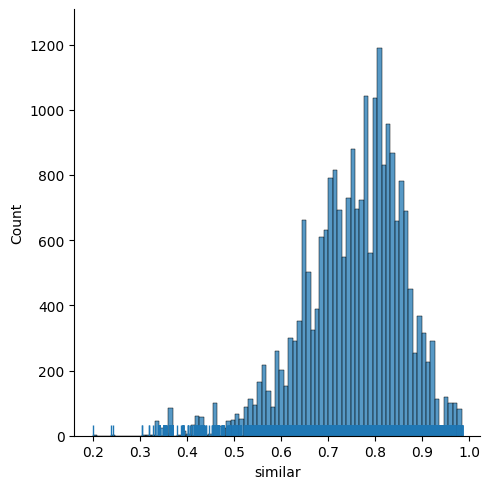

In [ ]:
sns.displot(df['similar'], rug=True)
plt.show()

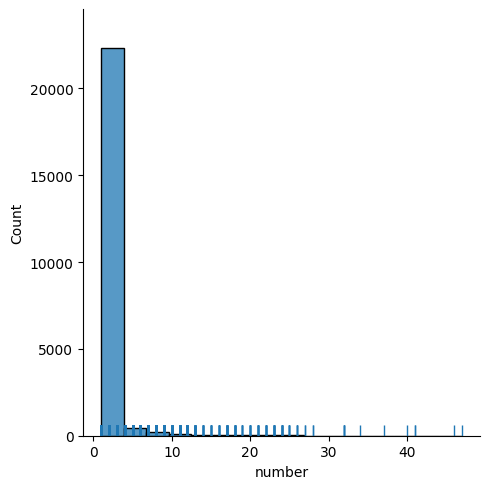

In [ ]:
sns.displot(df['number'], rug=True)
plt.show()

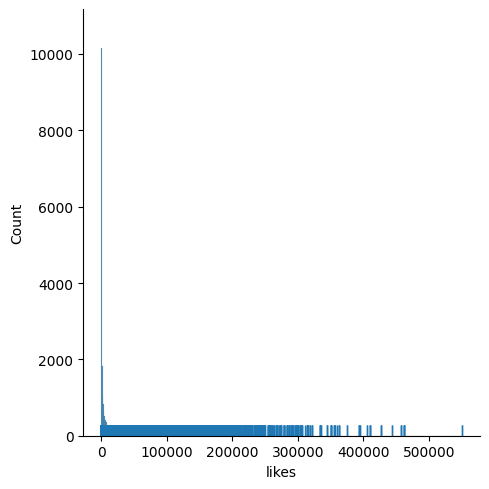

In [ ]:
sns.displot(df['likes'], rug=True)
plt.show()

## number와 likes를 0과 1 사이의 값으로 나타내주기 위해서 MinMaxScaler 사용

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
transformer = MinMaxScaler()
x_data = df['number'].to_numpy()
x_data = x_data.reshape(-1,1)
df['number'] = transformer.fit_transform(x_data)

y_data = df['likes'].to_numpy()
y_data = y_data.reshape(-1,1)
df['likes'] = transformer.fit_transform(y_data)

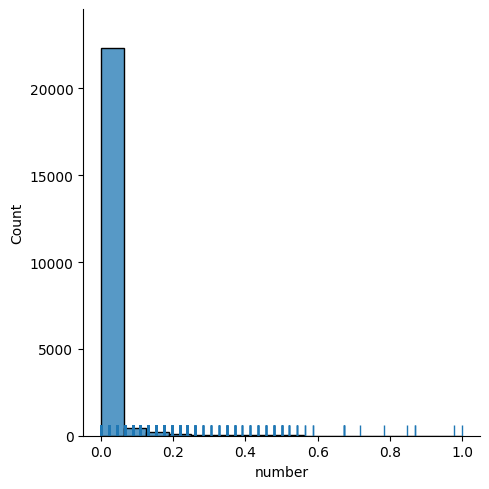

In [ ]:
sns.displot(df['number'], rug=True)
plt.show()

<ipython-input-153-b8857ed9d2ec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['likes'], rug=True)


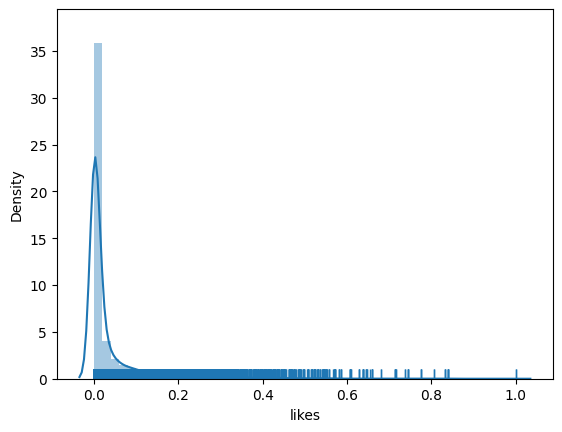

In [ ]:
sns.distplot(df['likes'], rug=True)
plt.show()

In [ ]:
df.head(3)

,title,artist,specific_tag,label,number,likes,file_name,image,similar
0,! (느낌표),오늘 (Today),"[미세먼지, 먼지, 저리가, 날려버려, 날씨, 신나는]",foggy,0.0,0.001648,! (느낌표)_오늘 (Today),https://cdnimg.melon.co.kr/cm/album/images/022...,0.771605
1,"""Méditation"" from Thaïs",Joshua Bell,"[클래식, 여름, 연주곡, 장마, 휴식]",rainy,0.0,0.000013,%2Méditation%2 from Thaïs_Joshua Bell,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.686341
2,#LoveSTAY,Stray Kids (스트레이 키즈),"[노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁]",sunrise_sunset,0.0,0.012426,#LoveSTAY_Stray Kids (스트레이 키즈),https://cdnimg.melon.co.kr/cm2/album/images/11...,0.720676


## 노래와 가수의 인기보다 label과의 관련성을 더 중요시하기 위해 (number, likes, similar)에 (4.5, 1, 4.5)로 가중치 부여

In [ ]:
df['final'] = df['number'] * 4.5 + df['likes'] * 1 + df['similar'] * 4.5
df.head(3)

,title,artist,specific_tag,label,number,likes,file_name,image,similar,final
0,! (느낌표),오늘 (Today),"[미세먼지, 먼지, 저리가, 날려버려, 날씨, 신나는]",foggy,0.0,0.001648,! (느낌표)_오늘 (Today),https://cdnimg.melon.co.kr/cm/album/images/022...,0.771605,3.473872
1,"""Méditation"" from Thaïs",Joshua Bell,"[클래식, 여름, 연주곡, 장마, 휴식]",rainy,0.0,0.000013,%2Méditation%2 from Thaïs_Joshua Bell,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.686341,3.088547
2,#LoveSTAY,Stray Kids (스트레이 키즈),"[노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁]",sunrise_sunset,0.0,0.012426,#LoveSTAY_Stray Kids (스트레이 키즈),https://cdnimg.melon.co.kr/cm2/album/images/11...,0.720676,3.255469


In [ ]:
df.to_csv('/content/drive/MyDrive/bitamin_project/csv/final_playlist_파생변수생성.csv')

In [ ]:
len(df)

23219

In [ ]:
duplicate_rows = df[df.duplicated(subset=['title', 'artist','label'])]
len(duplicate_rows)

595

In [ ]:
df = df.drop_duplicates(subset=['title', 'artist','label'])
len(df)

22624

In [ ]:
df[df['label']=='snowy'].sort_values(by='final', ascending=False).head(10)

,title,artist,specific_tag,label,number,likes,file_name,image,similar,final
650,All I Want for Christmas Is You,Mariah Carey,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 크리스마스캐롤, 겨울노래, pub...",snowy,0.717391,0.395711,All I Want for Christmas Is You_Mariah Carey,https://cdnimg.melon.co.kr/cm2/album/images/00...,0.731114,6.913984
11129,Santa Tell Me,Ariana Grande,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 크리스마스캐롤, 겨울노래, pub...",snowy,0.586957,0.422504,Santa Tell Me_Ariana Grande,https://cdnimg.melon.co.kr/cm/album/images/022...,0.736969,6.380167
22402,첫 눈,EXO,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 탑백, TOP100, 인기, 차트...",snowy,0.543478,0.384723,첫 눈_EXO,https://cdnimg.melon.co.kr/cm/album/images/022...,0.726388,6.099123
11738,Snowman,Sia,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 크리스마스캐롤, 겨울노래, pub...",snowy,0.500000,0.450776,Snowman_Sia,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.751866,6.084171
18806,미리 메리 크리스마스 (Feat. 천둥 Of MBLAQ),아이유,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 탑백, TOP100, 인기, 차트...",snowy,0.521739,0.310736,미리 메리 크리스마스 (Feat. 천둥 Of MBLAQ)_아이유,https://cdnimg.melon.co.kr/cm/album/images/010...,0.751019,6.038147
13810,Underneath The Tree,Kelly Clarkson,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 크리스마스캐롤, 겨울노래, pub...",snowy,0.521739,0.090465,Underneath The Tree_Kelly Clarkson,https://cdnimg.melon.co.kr/cm/album/images/022...,0.736463,5.752377
7145,Last Christmas,Ariana Grande,"[감성, 크리스마스, 추운날씨, 눈오는날, 겨울, 팝송, 포근한, 캐롤, 행복한, ...",snowy,0.413043,0.109332,Last Christmas_Ariana Grande,https://cdnimg.melon.co.kr/cm/album/images/022...,0.796661,5.553004
17897,눈 (Feat. 이문세),Zion.T,"[겨울, 눈오는날, 따뜻한, 발라드, 잔잔한, 추억, 추위, 연말, 포근한, 일상,...",snowy,0.478261,0.226585,눈 (Feat. 이문세)_Zion.T,https://cdnimg.melon.co.kr/cm/album/images/101...,0.700026,5.528877
9499,"Oh Santa! (Feat. Ariana Grande, Jennifer Hudson)",Mariah Carey,"[크리스마스, 크리스마스캐롤, 겨울노래, pub, 겨울감성, 추위, 따뜻한, 찬바람...",snowy,0.369565,0.032409,"Oh Santa! (Feat. Ariana Grande, Jennifer Hudso...",https://cdnimg.melon.co.kr/cm2/album/images/10...,0.838463,5.468535
22588,크리스마스니까,"성시경, 박효신, 이석훈, 서인국, VIXX (빅스)","[눈오는날, 탑백, TOP100, 인기, 차트, 눈, 겨울, 첫눈, 눈_오는_날, ...",snowy,0.369565,0.294894,"크리스마스니까_성시경, 박효신, 이석훈, 서인국, VIXX (빅스)",https://cdnimg.melon.co.kr/cm/album/images/021...,0.748814,5.327598


In [ ]:
df.groupby('label').count()

,title,artist,specific_tag,number,likes,file_name,image,similar,final
label,,,,,,,,,
foggy,5035,5035,5035,5035,5035,5035,5035,5035,5035
rainy,4362,4362,4362,4362,4362,4362,4362,4362,4362
snowy,3591,3591,3591,3591,3591,3591,3591,3591,3591
sunny,4770,4770,4770,4770,4770,4770,4770,4770,4770
sunrise_sunset,4866,4866,4866,4866,4866,4866,4866,4866,4866


In [ ]:
df = pd.read_csv('')

In [ ]:
def recommend(input):
  df_input = df[df['label']==input]
  df_input.sort_values(by='final', ascending=False, inplace=True)
  df_input = df_input[:len(df_input)//20] # 상위 5% 추출
  output = df_input.sample(n=10, replace=False)

  return output

In [ ]:
df_input = df[df['label']=='sunny']
df_input.sort_values(by='final', ascending=False, inplace=True)
df_input = df_input[:len(df_input)//10] # 상위 10% 추출
df_input.tail()

<ipython-input-36-a0fb7b492665>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True) #실제로는 similar가 아닌 최종 판단 변수로 진행해야 함


,title,artist,specific_tag,label,number,likes,similar,final
36192,여행,볼빨간사춘기,"['시원', '맑은날', '산뜻함', '여행', '신나는_음악', '인디음악', '...",sunny,0.278689,0.543501,0.689968,4.961627
32738,봄날,방탄소년단,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.016393,1.000000,0.695143,4.846146
33482,빨간 맛 (Red Flavor),Red Velvet (레드벨벳),"['여름', '댄스곡', '여돌', '남돌', '여행', '아이돌', '기분업', ...",sunny,0.213115,0.427662,0.729126,4.624288
31227,롤린 (Rollin'),브레이브걸스,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.163934,0.546947,0.704874,4.569129
6137,Dynamite,방탄소년단,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.098361,0.832168,0.606964,4.485635
...,...,...,...,...,...,...,...,...
13801,Me Too,Ayanis,"['운동', '스트레스', '다이어트', '신나는', '드라이브', '헬스', '텐...",sunny,0.000000,0.009797,0.786625,3.166094
15243,No Time For Tears,"Nathan Dawe, Little Mix","['여름', '기분전환', '청량한', '시원한', '텐션업', '드라이브', '여...",sunny,0.000000,0.002444,0.790189,3.165644
18069,SAD,Eli,"['드라이브', '기분업업', '여행을', '출근', '퇴근']",sunny,0.000000,0.007335,0.787700,3.165471
12852,Lost,Blake Rose,"['드라이브', '기분업업', '여행을', '출근', '퇴근']",sunny,0.000000,0.007293,0.787700,3.165388


In [ ]:
recommend('sunny')

<ipython-input-178-82e43ff37f52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True)


,title,artist,specific_tag,label,number,likes,file_name,image,similar,final
2965,Cupid (Feat. PENOMECO),pH-1,"[드라이브, 맑은날, 맑은날씨, 화창한날씨, 아침, 시작, 출근, 퇴근, 여행, 내...",sunny,0.021739,0.097553,Cupid (Feat. PENOMECO)_pH-1,https://cdnimg.melon.co.kr/cm/album/images/101...,0.919450,4.332902
22329,차와 이야기를 나눠요,레피 (repi),"[피아노, 초여름, 뉴에이지피아노, 여름, 늦봄, 카페, 휴식, 감성, 맑은날, 아...",sunny,0.543478,0.000036,차와 이야기를 나눠요_레피 (repi),https://cdnimg.melon.co.kr/cm2/album/images/10...,0.747428,5.809117
22114,조깅,LUCY,"[드라이브, 맑은날, 맑은날씨, 화창한날씨, 아침, 시작, 출근, 퇴근, 여행, 내...",sunny,0.065217,0.058409,조깅_LUCY,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.872326,4.277356
8265,Maniac,Conan Gray,"[드라이브, 기분전환, 출퇴근길, 여행, 산책, 휴식, 힐링, 스트레스, 운동, 맑...",sunny,0.152174,0.302861,Maniac_Conan Gray,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.750274,4.363878
22574,퀸카 (Queencard),(여자)아이들,"[아이돌, 여름, 기분전환, 더위, 여행, 드라이브, 신나는, 청량감, 트로피컬, ...",sunny,0.021739,0.238871,퀸카 (Queencard)_(여자)아이들,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.872528,4.263072
3663,ETA,NewJeans,"[아이돌, 여름, 기분전환, 더위, 여행, 드라이브, 신나는, 청량감, 트로피컬, ...",sunny,0.043478,0.165113,ETA_NewJeans,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.872528,4.287140
23116,화용월태(花容月態),도화,"[뉴에이지, 사무실, 월요병, 연주곡, 배경음악, 공부할때, 화창한날, 북카페, 커...",sunny,0.217391,0.000013,화용월태(花容月態)_도화,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.729081,4.259137
20926,에잇(Prod.&Feat. SUGA of BTS),아이유,"[방탄소년단, 최신노래, 맑은날, 월요병, 봄, 사랑, 아이돌, 아이유, 신나는, ...",sunny,0.065217,0.716451,에잇(Prod.&Feat. SUGA of BTS)_아이유,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.793126,4.578997
4466,Freak (Prod. Slom),"릴보이 (lIlBOI), 원슈타인, Chillin Homie, 스카이민혁 (Skym...","[맑은날, 봄날, 따스한, 숨은명곡]",sunny,0.000000,0.141145,"Freak (Prod. Slom)_릴보이 (lIlBOI), 원슈타인, Chillin...",https://cdnimg.melon.co.kr/cm2/album/images/10...,0.918976,4.276538
20584,아무노래,지코 (ZICO),"[여행, 드라이브, 신나는, 볼륨업, 댄스, 도입부맛집, 흥폭발]",sunny,0.000000,0.506208,아무노래_지코 (ZICO),https://cdnimg.melon.co.kr/cm2/album/images/10...,0.867799,4.411304


In [ ]:
df.to_csv('/content/drive/MyDrive/bitamin_project/csv/playlist_recommend.csv', index=False)

# 데이터 불러와서 추천하기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bitamin_project/csv/playlist_recommend.csv')
df.head()

,title,artist,specific_tag,label,number,likes,file_name,image,similar,final
0,! (느낌표),오늘 (Today),"['미세먼지', '먼지', '저리가', '날려버려', '날씨', '신나는']",foggy,0.0,0.001648,! (느낌표)_오늘 (Today),https://cdnimg.melon.co.kr/cm/album/images/022...,0.771605,3.473872
1,"""Méditation"" from Thaïs",Joshua Bell,"['클래식', '여름', '연주곡', '장마', '휴식']",rainy,0.0,0.000013,%2Méditation%2 from Thaïs_Joshua Bell,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.686341,3.088547
2,#LoveSTAY,Stray Kids (스트레이 키즈),"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset,0.0,0.012426,#LoveSTAY_Stray Kids (스트레이 키즈),https://cdnimg.melon.co.kr/cm2/album/images/11...,0.720676,3.255469
3,#menow,프로미스나인,"['가요', '여름', '여행', '기분전환', '드라이브', '휴가', '시원한'...",sunny,0.0,0.028479,#menow_프로미스나인,https://cdnimg.melon.co.kr/cm2/album/images/11...,0.841326,3.814446
4,#봄,꽃가람,"['비오는날', '봄비', '비노래', '봄', '봄노래', '그리움', '비내리는...",rainy,0.0,0.000024,#봄_꽃가람,https://cdnimg.melon.co.kr/cm/album/images/101...,0.825507,3.714807


In [ ]:
recommend('rainy')

<ipython-input-5-82e43ff37f52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True)


,title,artist,specific_tag,label,number,likes,file_name,image,similar,final
3337,Don't Cry,Ruel,"['비오는날', '비올때', '비', '소나기', '여름비', '비캐롤', '장마'...",rainy,0.021739,0.006436,Don't Cry_Ruel,https://cdnimg.melon.co.kr/cm2/album/images/10...,0.967941,4.459997
14803,bath,offonoff (오프온오프),"['흐린날', '침대', '센치', '비오는날', '우울', '잠들기전', '사색'...",rainy,0.065217,0.088270,bath_offonoff (오프온오프),https://cdnimg.melon.co.kr/cm/album/images/027...,0.897468,4.420355
6470,It's Raining (Feat. 버벌진트),스텔라장 (Stella Jang),"['비', '비오는날', '센치한', '혼자', '감성적인', '발라드', '편안한...",rainy,0.173913,0.031296,It's Raining (Feat. 버벌진트)_스텔라장 (Stella Jang),https://cdnimg.melon.co.kr/cm/album/images/023...,0.813456,4.474456
19037,비오는 거리,이승훈,"['비', '비오는날', '센치한', '혼자', '감성적인', '발라드', '편안한...",rainy,0.152174,0.030052,비오는 거리_이승훈,https://cdnimg.melon.co.kr/cm/album/images/000...,0.861795,4.592913
8379,Monologue,버즈,"['비가오는날엔', '비캐롤', '빗소리', '비올때', '장마', '봄비', '여...",rainy,0.021739,0.155032,Monologue_버즈,https://cdnimg.melon.co.kr/cm2/album/images/00...,0.974061,4.636132
19784,숨비소리,안녕하신가영,"['장마', '여름비']",rainy,0.000000,0.003197,숨비소리_안녕하신가영,https://cdnimg.melon.co.kr/cm/album/images/026...,0.983640,4.429575
8554,Mr.gloomy,백예린 (Yerin Baek),"['비오는날', '감성', '기분전환', '출퇴근', '밤', '비', '잔잔한',...",rainy,0.065217,0.045529,Mr.gloomy_백예린 (Yerin Baek),https://cdnimg.melon.co.kr/cm2/album/images/10...,0.900789,4.392556
18985,비가와 (Rain),"소유 (SOYOU), 백현 (BAEKHYUN)","['비', '비오는날', '센치한', '혼자', '감성적인', '발라드', '편안한...",rainy,0.500000,0.237451,"비가와 (Rain)_소유 (SOYOU), 백현 (BAEKHYUN)",https://cdnimg.melon.co.kr/cm/album/images/100...,0.829792,6.221517
21241,일기,캔디맨,"['비가오는날엔', '비캐롤', '빗소리', '비올때', '장마', '봄비', '여...",rainy,0.021739,0.031838,일기_캔디맨,https://cdnimg.melon.co.kr/cm/album/images/000...,0.974061,4.512938
19049,비오는 날 뭐해,하은 (포맨),"['비', '비오는날', '센치한', '혼자', '감성적인', '발라드', '편안한...",rainy,0.521739,0.109872,비오는 날 뭐해_하은 (포맨),https://cdnimg.melon.co.kr/cm/album/images/103...,0.802701,6.069854
